## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from pytorchers.clf import BaseNNClassifier, NNClassifierEstimator
from pytorchers.viz import ForwardTracker

## Generate Synthetic Binary Classification Data

In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_classes=2,
    class_sep=0.8,
    random_state=42,
)

# Convert to DataFrame for easier manipulation
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
data = pd.DataFrame(X, columns=feature_names)
data["target"] = y

## Basic EDA

In [ ]:
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,0.925100,0.978124,0.493516,0.590880,-0.414278,1.147020,1.222403,1.357325,0.966041,-1.570825,1
1,-0.764641,3.438629,-1.522415,-1.341705,1.416697,4.581310,2.981374,-0.890254,1.438826,-3.910867,0
2,0.316313,1.965426,-0.628486,-0.186923,0.292518,1.242381,1.123987,-1.958175,-0.348803,-1.886244,0
3,0.337282,0.766618,-0.115420,0.470755,-0.758516,0.671440,0.311074,-1.034471,-1.654176,-1.500189,1
4,0.078385,0.865828,-1.724917,-2.035667,0.515107,0.531249,-0.883037,0.598330,-0.524283,0.965490,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  1000 non-null   float64
 1   feature_1  1000 non-null   float64
 2   feature_2  1000 non-null   float64
 3   feature_3  1000 non-null   float64
 4   feature_4  1000 non-null   float64
 5   feature_5  1000 non-null   float64
 6   feature_6  1000 non-null   float64
 7   feature_7  1000 non-null   float64
 8   feature_8  1000 non-null   float64
 9   feature_9  1000 non-null   float64
 10  target     1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 86.1 KB


In [ ]:
data.isnull().mean()

feature_0    0.0
feature_1    0.0
feature_2    0.0
feature_3    0.0
feature_4    0.0
feature_5    0.0
feature_6    0.0
feature_7    0.0
feature_8    0.0
feature_9    0.0
target       0.0
dtype: float64

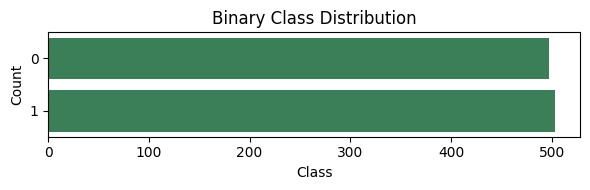

In [ ]:
# Class distribution
fig, ax = plt.subplots(figsize=(6, 2))
sns.countplot(data=data, y="target", color="seagreen", ax=ax)
ax.set_title("Binary Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
fig.tight_layout()

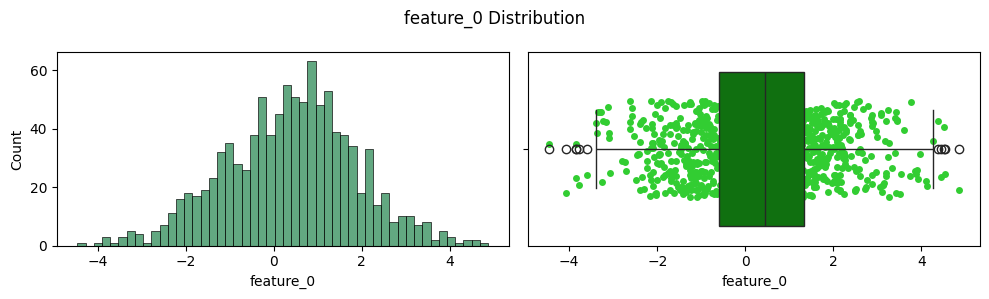

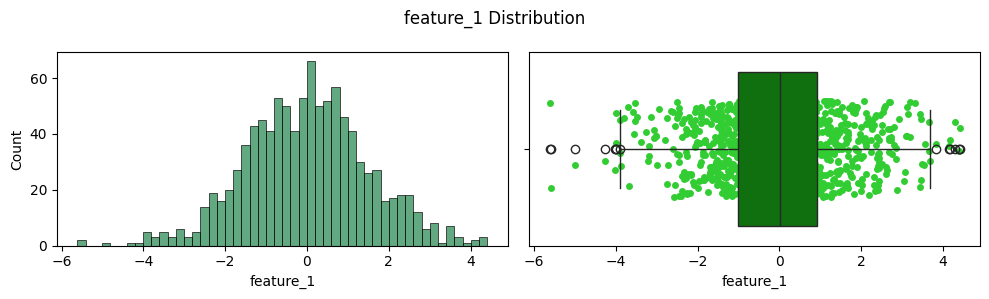

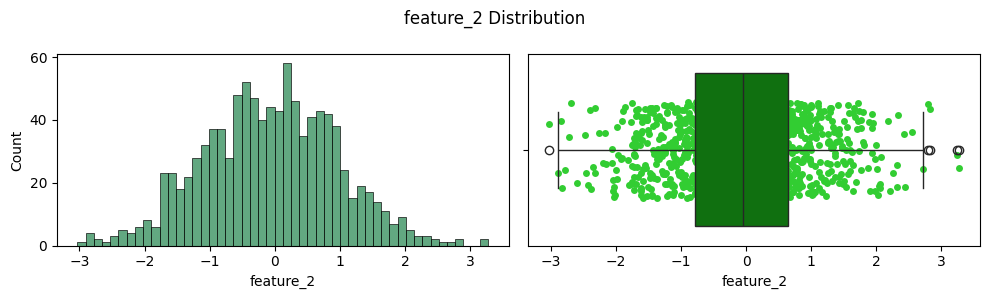

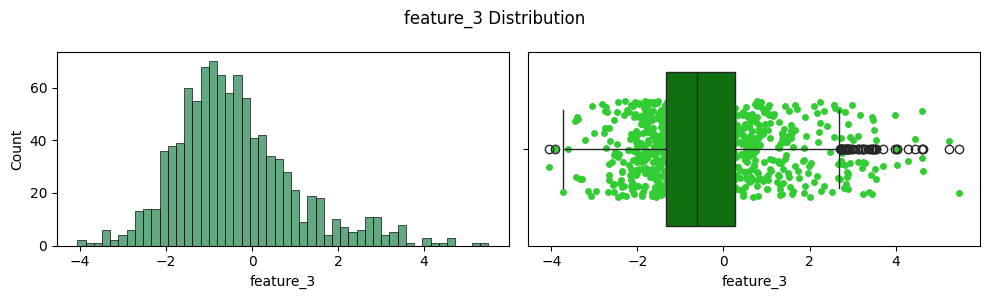

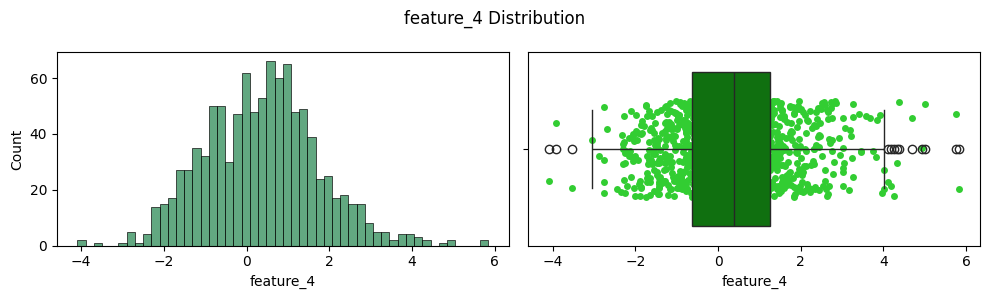

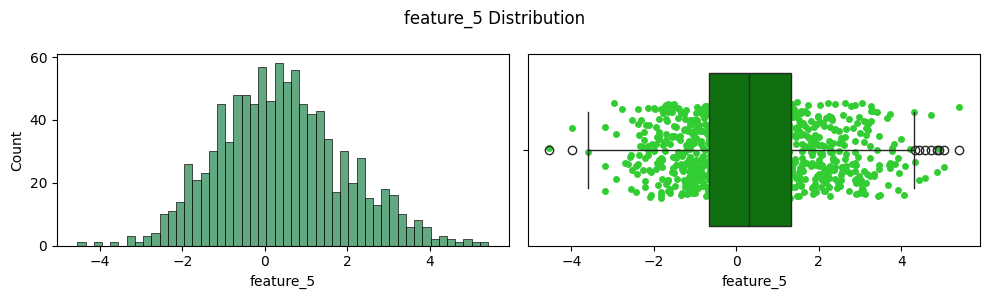

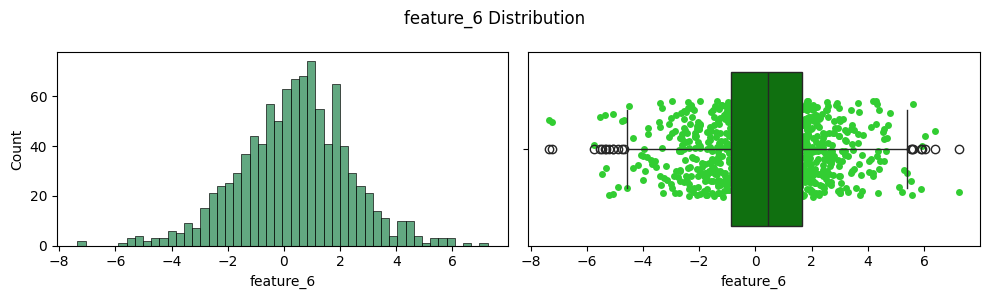

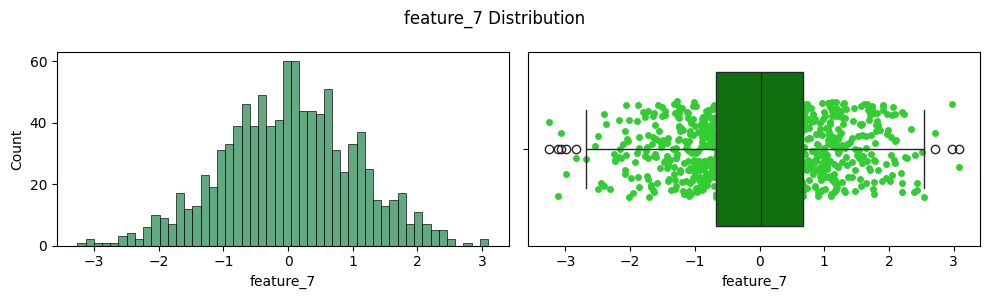

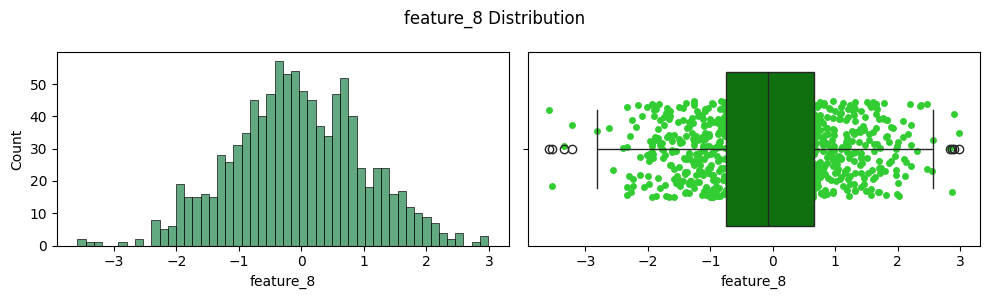

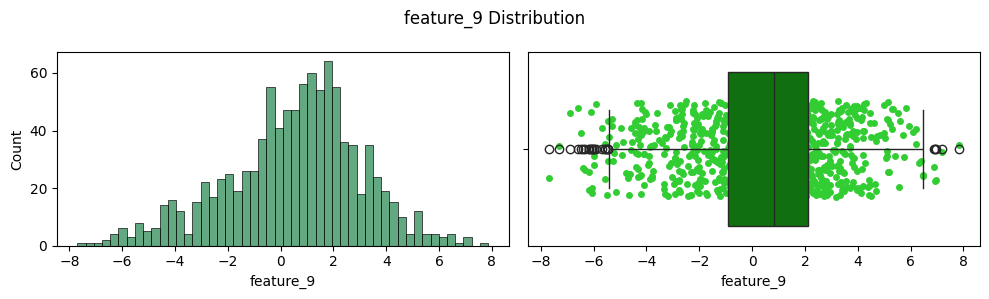

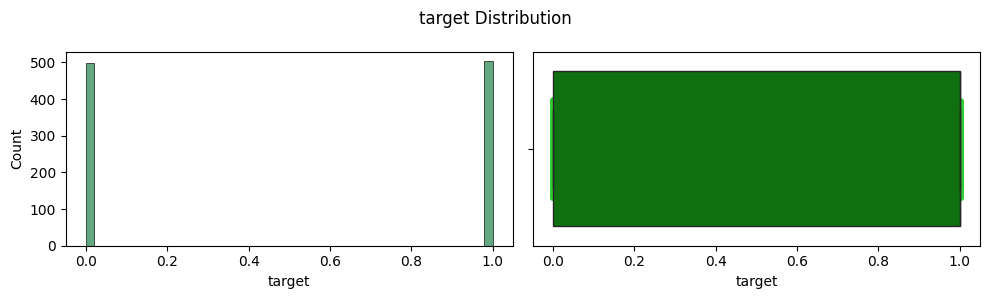

In [ ]:
for c in data.columns:
    fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
    sns.histplot(data[c], bins=50, color="seagreen", ax=ax[0])
    sns.stripplot(data[c], orient="h", jitter=0.25, zorder=1, color="limegreen", ax=ax[1])
    sns.boxplot(data[c], color="green", orient="h", ax=ax[1])
    fig.suptitle(f"{c} Distribution")
    fig.tight_layout()

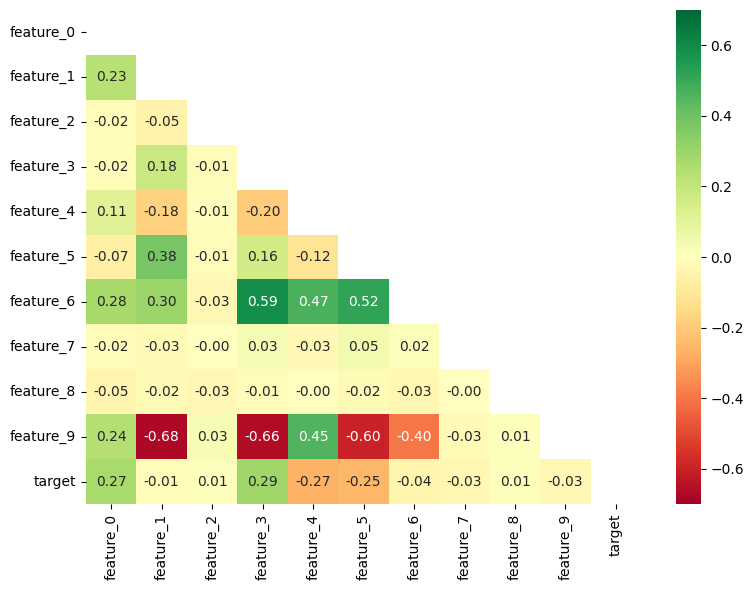

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    data.corr(),
    annot=True,
    cmap="RdYlGn",
    center=0,
    vmax=0.7,
    vmin=-0.7,
    fmt=".2f",
    mask=np.triu(np.ones_like(data.corr(), dtype=bool)),
    ax=ax,
)
fig.tight_layout()

## Modeling and sklearn compatibility

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("target", axis=1), data["target"], test_size=0.2, random_state=42
)

In [ ]:
base_model = BaseNNClassifier(input_size=X_train.shape[1], layers=[64, 32], n_classes=2)
estimator = NNClassifierEstimator(model=base_model, epochs=50)

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()), ("nn_classifier", estimator)])

pipe.fit(X_train, y_train)

Epoch: 0/50 - Train Loss 0.6637 - Val Loss: 0.6654 - Train Acc: 0.7014 - Val Acc: 0.7000
Epoch: 1/50 - Train Loss 0.6303 - Val Loss: 0.6272 - Train Acc: 0.8181 - Val Acc: 0.8375
Epoch: 2/50 - Train Loss 0.5821 - Val Loss: 0.5741 - Train Acc: 0.8167 - Val Acc: 0.8375
Epoch: 3/50 - Train Loss 0.5236 - Val Loss: 0.5105 - Train Acc: 0.8278 - Val Acc: 0.8500
Epoch: 4/50 - Train Loss 0.4642 - Val Loss: 0.4458 - Train Acc: 0.8375 - Val Acc: 0.8625
Epoch: 5/50 - Train Loss 0.4174 - Val Loss: 0.3853 - Train Acc: 0.8417 - Val Acc: 0.8750
Epoch: 6/50 - Train Loss 0.3871 - Val Loss: 0.3461 - Train Acc: 0.8444 - Val Acc: 0.9250
Epoch: 7/50 - Train Loss 0.3662 - Val Loss: 0.3164 - Train Acc: 0.8472 - Val Acc: 0.9250
Epoch: 8/50 - Train Loss 0.3498 - Val Loss: 0.2926 - Train Acc: 0.8597 - Val Acc: 0.9250
Epoch: 9/50 - Train Loss 0.3373 - Val Loss: 0.2713 - Train Acc: 0.8653 - Val Acc: 0.9375
Epoch: 10/50 - Train Loss 0.3266 - Val Loss: 0.2647 - Train Acc: 0.8653 - Val Acc: 0.9250
Epoch: 11/50 - Train

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('nn_classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,model,"BaseNNClassif..., bias=True) )"
,loss,'crossentropy'
,optimizer,'adam'
,lr,0.001


In [ ]:
y_pred = pipe.predict(X_test)
print(y_pred)

[0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0
 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1
 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1
 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1]


In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.95      0.94      0.95        88

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



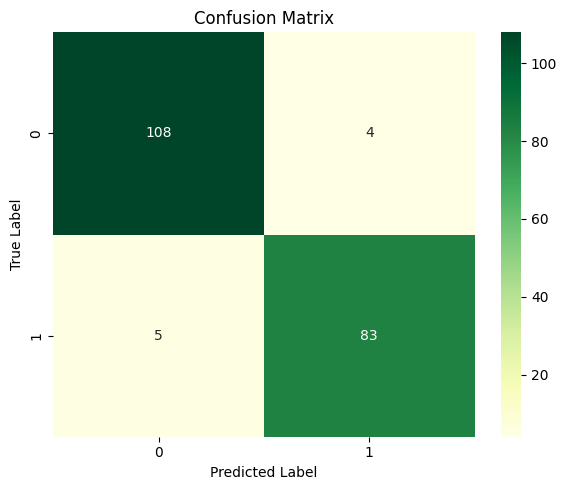

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn", ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
fig.tight_layout()

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(val_losses, label="Val Loss")
    ax1.set_title("Loss Over Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label="Train Accuracy")
    ax2.plot(val_accs, label="Val Accuracy")
    ax2.set_title("Accuracy Over Epochs")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    plt.show()

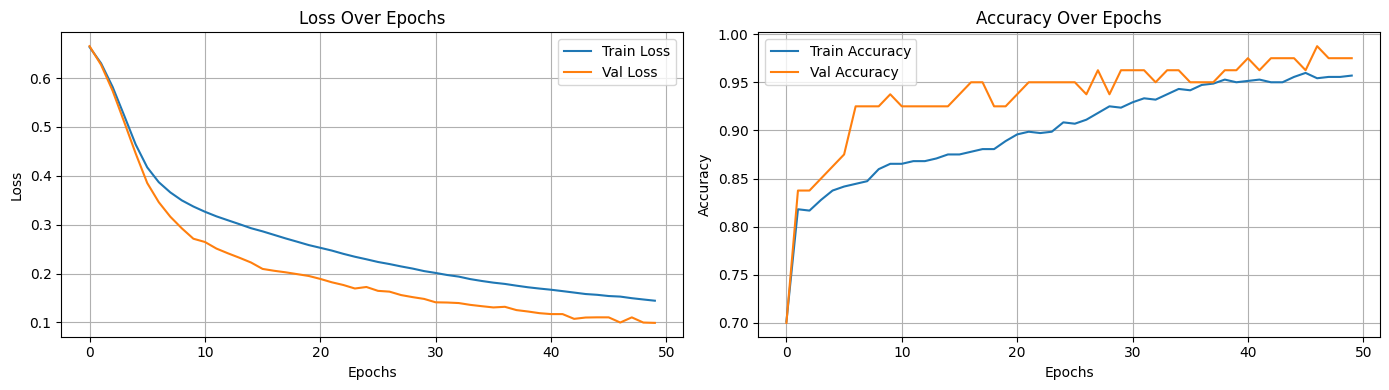

In [ ]:
plot_metrics(
    pipe.named_steps["nn_classifier"].train_losses_,
    pipe.named_steps["nn_classifier"].val_losses_,
    pipe.named_steps["nn_classifier"].train_accs_,
    pipe.named_steps["nn_classifier"].val_accs_,
)

In [ ]:
# Example with class weighting (useful if data is imbalanced)
pipe_balanced = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "nn_classifier",
            NNClassifierEstimator(
                model=BaseNNClassifier(input_size=X_train.shape[1], layers=[64, 32], n_classes=2),
                epochs=50,
                class_weight="balanced",
                verbose=False,
            ),
        ),
    ]
)
pipe_balanced.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('nn_classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,model,"BaseNNClassif..., bias=True) )"
,loss,'crossentropy'
,optimizer,'adam'
,lr,0.001


In [ ]:
y_pred_balanced = pipe_balanced.predict(X_test)
print("With Class Balancing:")
print(classification_report(y_test, y_pred_balanced))

With Class Balancing:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       112
           1       0.94      0.90      0.92        88

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



## Model Inspection

In [ ]:
class InspectableClassifier(nn.Module, ForwardTracker):
    def __init__(self, input_size, layers, n_classes=2):
        nn.Module.__init__(self)
        ForwardTracker.__init__(self)
        self.input_size = input_size
        self.layers = layers
        self.n_classes = n_classes
        for i in range(len(layers)):
            in_features = input_size if i == 0 else layers[i - 1]
            out_features = layers[i]
            setattr(self, f"fc{i}", nn.Linear(in_features, out_features))
        self.final_linear = nn.Linear(layers[-1], n_classes)

    def forward(self, x):
        for i in range(len(self.layers)):
            x = getattr(self, f"fc{i}")(x)
            x = nn.ReLU()(x)
        x = self.final_linear(x)
        return x

In [ ]:
def train_loop(model, train_set, val_set, loss_fn=None, epochs=50, verbose=True):
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()
    X_train = torch.tensor(train_set[0], dtype=torch.float32)
    y_train = torch.tensor(train_set[1], dtype=torch.long)
    X_val = torch.tensor(val_set[0], dtype=torch.float32)
    y_val = torch.tensor(val_set[1], dtype=torch.long)

    model.train()
    optimizer = torch.optim.Adam(model.parameters())
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            train_preds = model(X_train)
            val_preds = model(X_val)
            train_loss = loss_fn(train_preds, y_train).item()
            val_loss = loss_fn(val_preds, y_val).item()
            train_acc = (train_preds.argmax(dim=1) == y_train).float().mean().item()
            val_acc = (val_preds.argmax(dim=1) == y_val).float().mean().item()
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

        if verbose:
            print(
                f"Epoch: {epoch}/{epochs} - Train Loss {train_loss:.4f} - Val Loss: {val_loss:.4f}"
                f" - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}"
            )

    return train_losses, val_losses, train_accs, val_accs, model

In [ ]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [ ]:
train_losses, val_losses, train_accs, val_accs, model = train_loop(
    model=InspectableClassifier(input_size=X_train_transformed.shape[1], layers=[32, 32, 16]),
    train_set=(X_train_transformed, y_train.values),
    val_set=(X_test_transformed, y_test.values),
    epochs=50,
    verbose=True,
)

Epoch: 0/50 - Train Loss 0.6871 - Val Loss: 0.6829 - Train Acc: 0.5387 - Val Acc: 0.5750
Epoch: 1/50 - Train Loss 0.6751 - Val Loss: 0.6730 - Train Acc: 0.7200 - Val Acc: 0.7850
Epoch: 2/50 - Train Loss 0.6490 - Val Loss: 0.6463 - Train Acc: 0.7862 - Val Acc: 0.8350
Epoch: 3/50 - Train Loss 0.6024 - Val Loss: 0.5964 - Train Acc: 0.8087 - Val Acc: 0.8300
Epoch: 4/50 - Train Loss 0.5331 - Val Loss: 0.5229 - Train Acc: 0.8275 - Val Acc: 0.8400
Epoch: 5/50 - Train Loss 0.4495 - Val Loss: 0.4368 - Train Acc: 0.8413 - Val Acc: 0.8500
Epoch: 6/50 - Train Loss 0.3839 - Val Loss: 0.3686 - Train Acc: 0.8525 - Val Acc: 0.8650
Epoch: 7/50 - Train Loss 0.3477 - Val Loss: 0.3341 - Train Acc: 0.8587 - Val Acc: 0.8700
Epoch: 8/50 - Train Loss 0.3247 - Val Loss: 0.3115 - Train Acc: 0.8637 - Val Acc: 0.8700
Epoch: 9/50 - Train Loss 0.3101 - Val Loss: 0.2981 - Train Acc: 0.8712 - Val Acc: 0.8700
Epoch: 10/50 - Train Loss 0.2973 - Val Loss: 0.2883 - Train Acc: 0.8775 - Val Acc: 0.8800
Epoch: 11/50 - Train

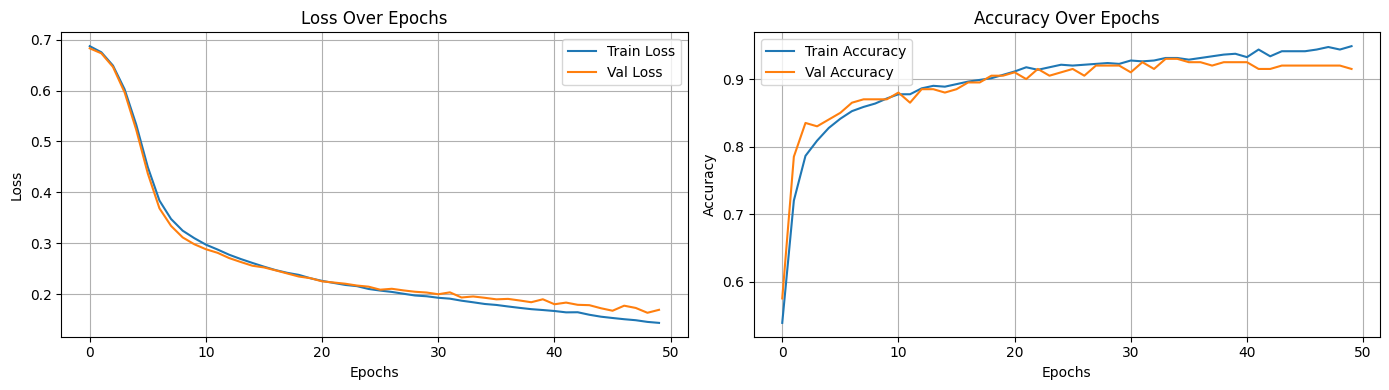

In [ ]:
plot_metrics(train_losses, val_losses, train_accs, val_accs)

/Users/soufiane/Desktop/perso/pytorchers/src/pytorchers/viz.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


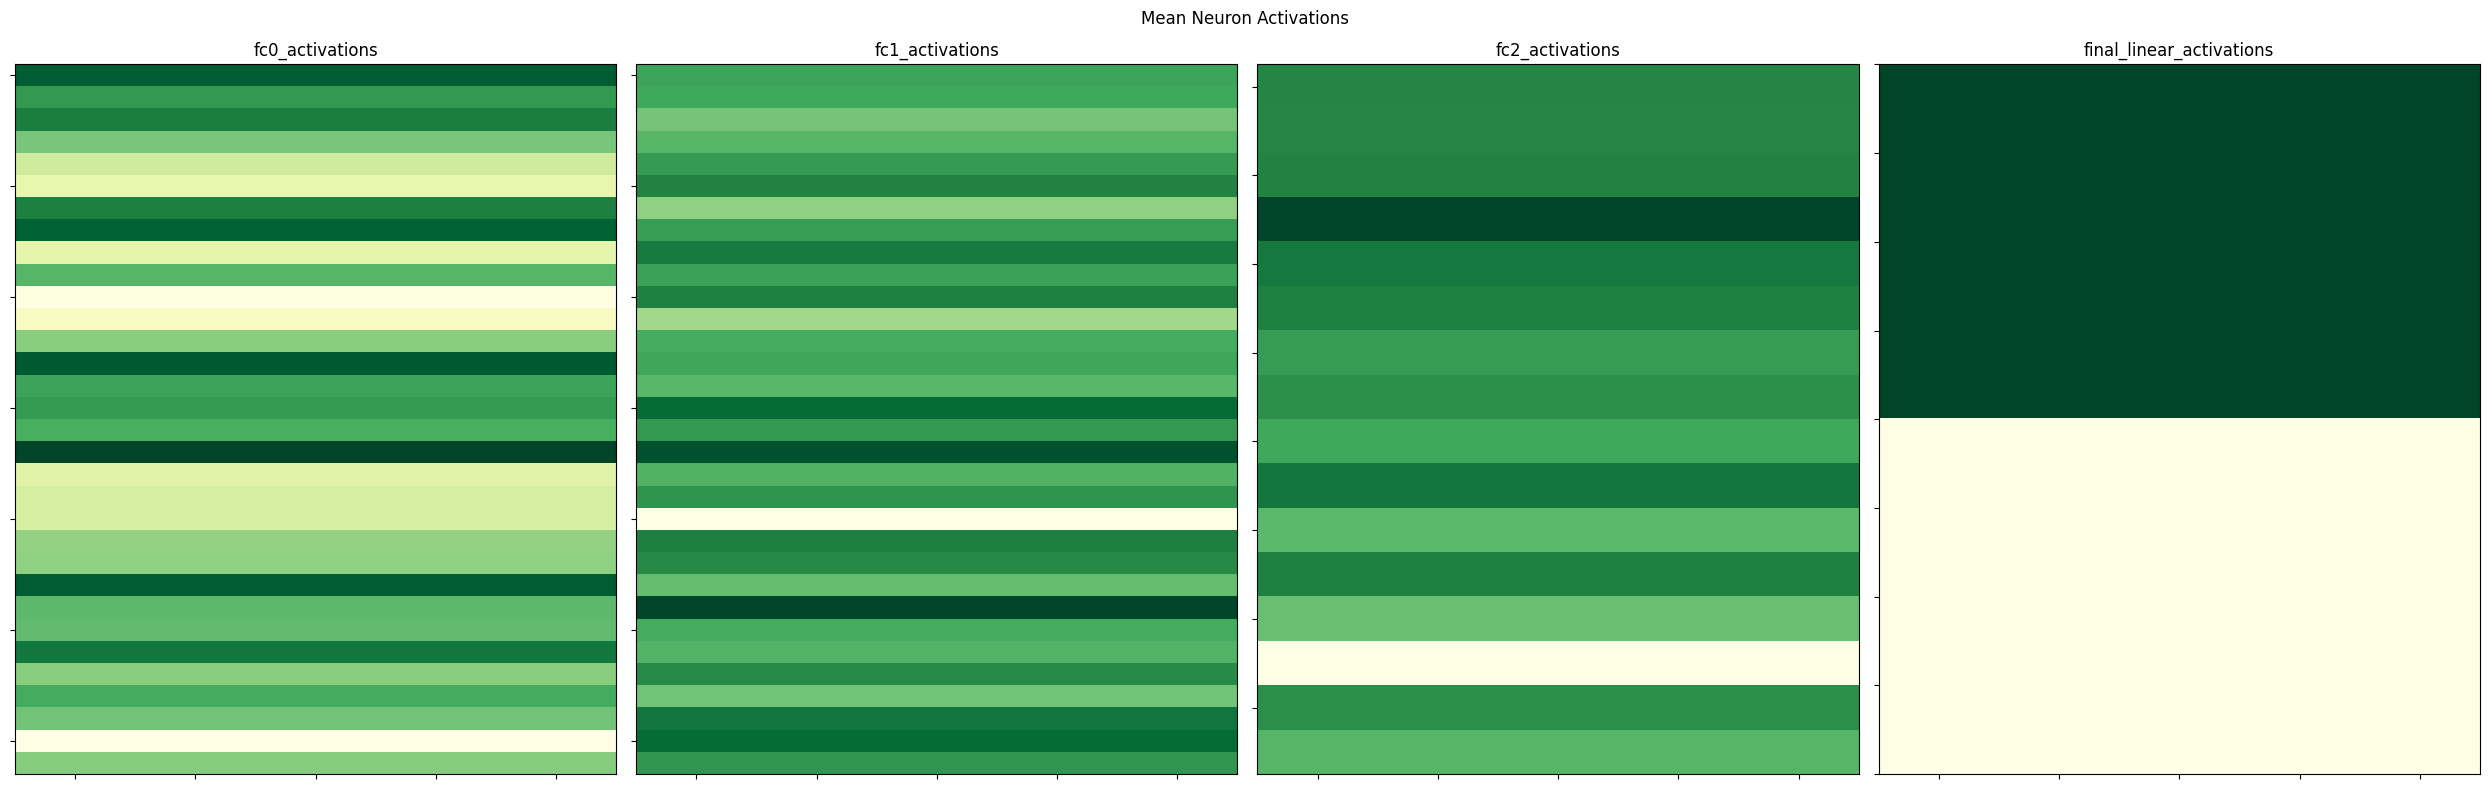

In [ ]:
# Visualize neuron activations
model.plot_activations(
    X=torch.tensor(X_test_transformed, dtype=torch.float32),
    y=torch.tensor(y_test.values, dtype=torch.long),
    fig_title="Mean Neuron Activations",
)

/Users/soufiane/Desktop/perso/pytorchers/src/pytorchers/viz.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


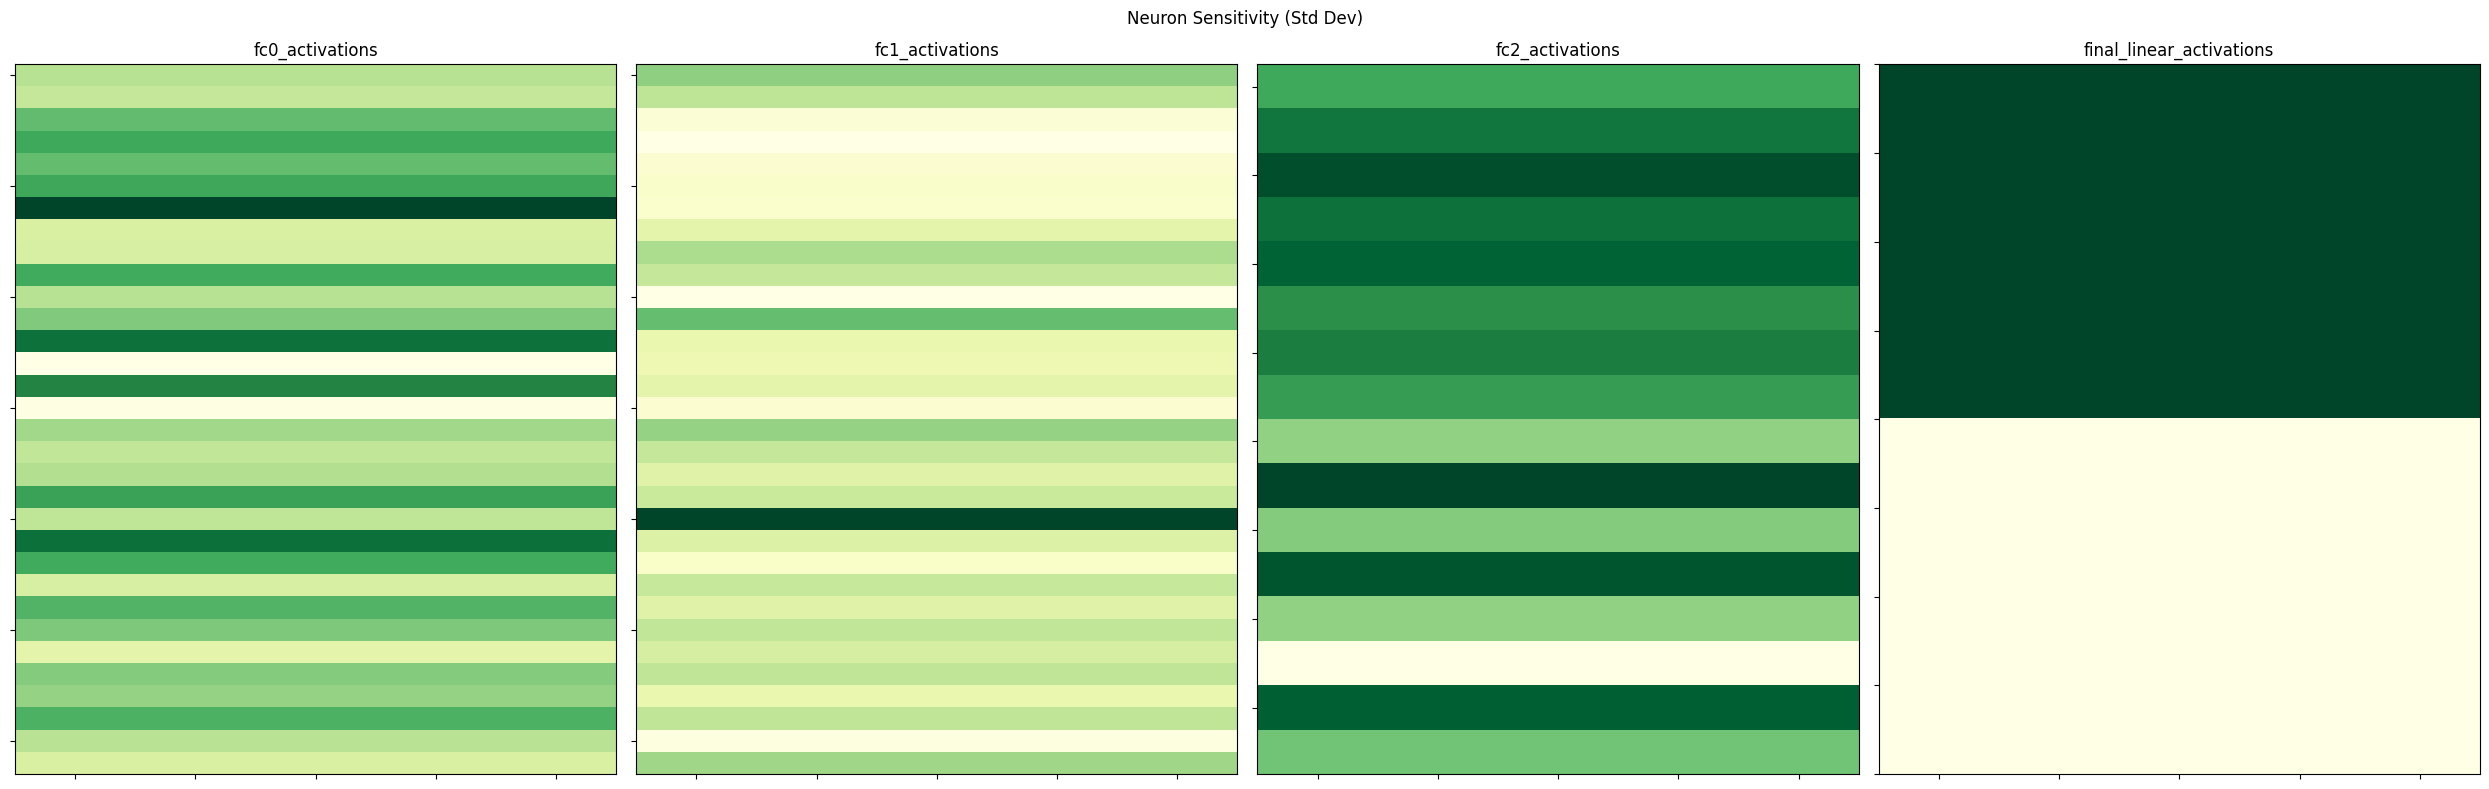

In [ ]:
# Visualize neuron sensitivity (std)
model.plot_activations(
    X=torch.tensor(X_test_transformed, dtype=torch.float32),
    y=torch.tensor(y_test.values, dtype=torch.long),
    agg_func=torch.std,
    fig_title="Neuron Sensitivity (Std Dev)",
)

/Users/soufiane/Desktop/perso/pytorchers/src/pytorchers/viz.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/soufiane/Desktop/perso/pytorchers/src/pytorchers/viz.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


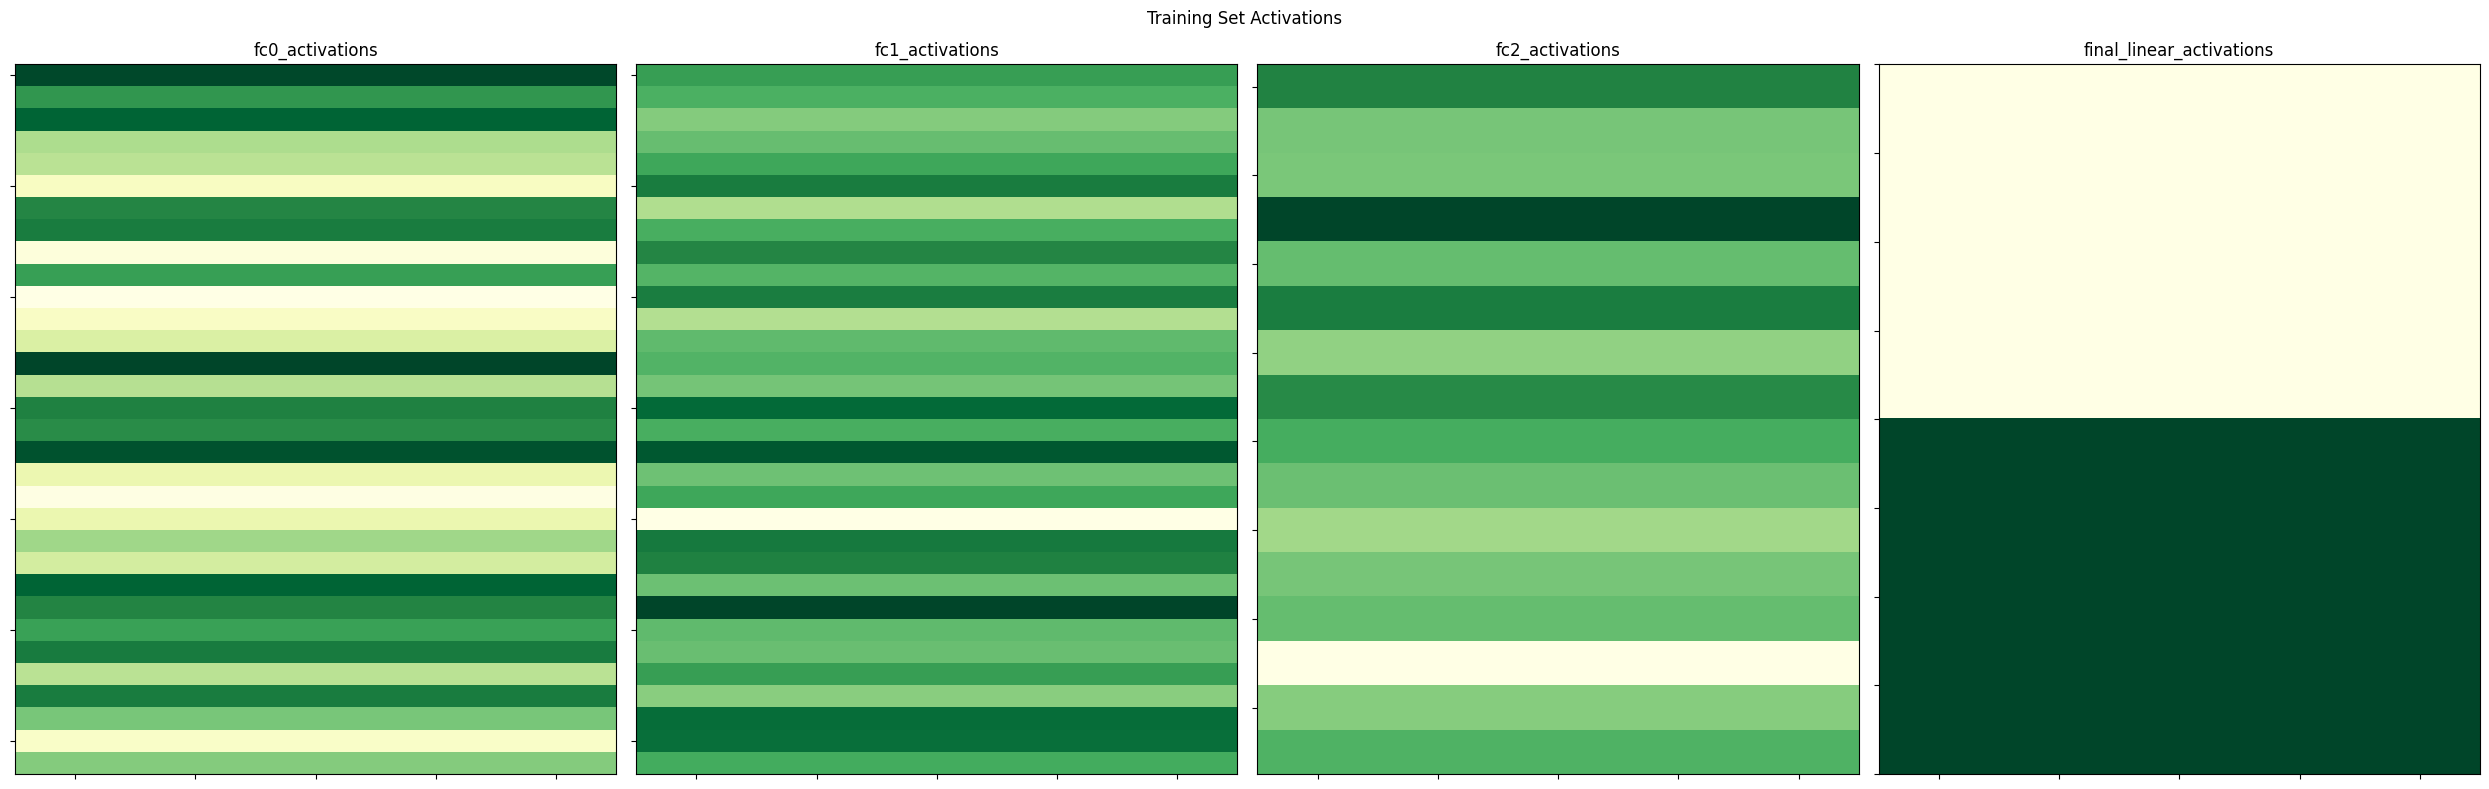

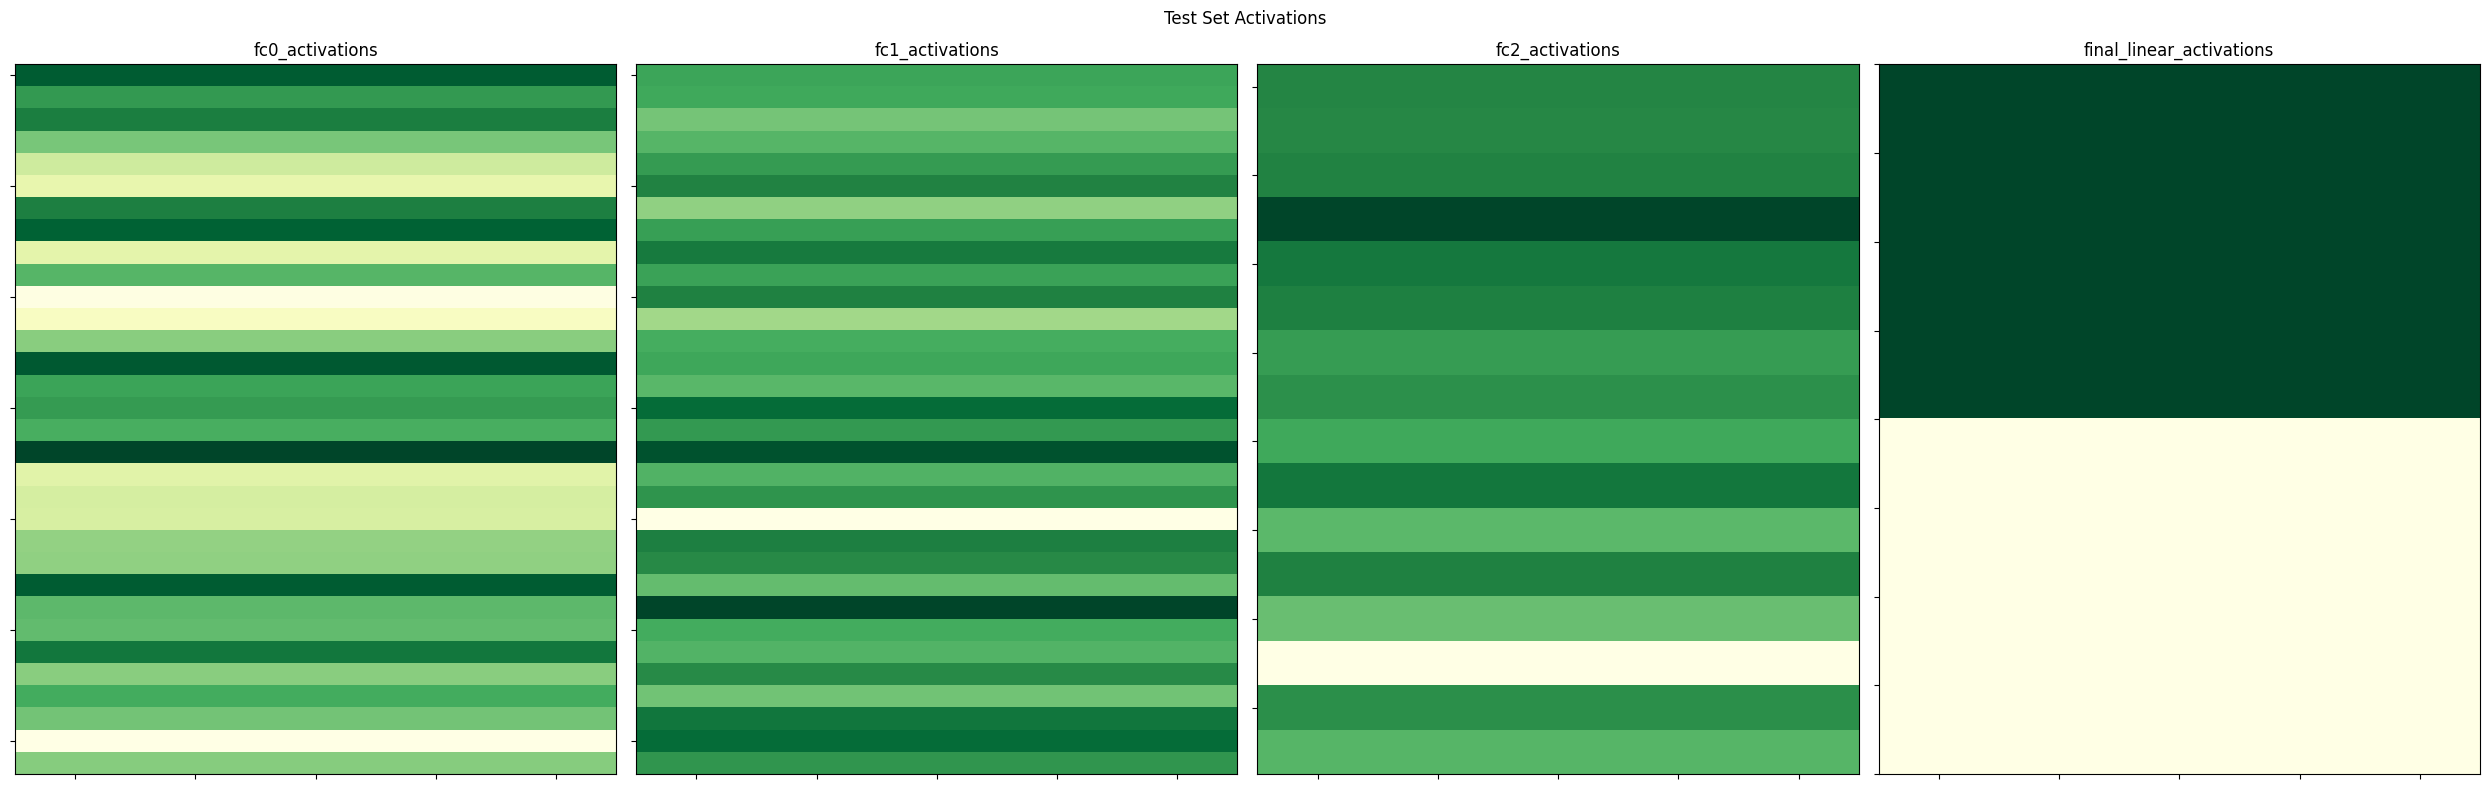

In [ ]:
# Compare train vs test activations
X_train_transformed_tn = torch.tensor(X_train_transformed, dtype=torch.float32)
y_train_tn = torch.tensor(y_train.values, dtype=torch.long)
X_val_transformed_tn = torch.tensor(X_test_transformed, dtype=torch.float32)
y_val_tn = torch.tensor(y_test.values, dtype=torch.long)

model.plot_compared_activations(
    (X_train_transformed_tn, y_train_tn),
    (X_val_transformed_tn, y_val_tn),
    fig_title1="Training Set Activations",
    fig_title2="Test Set Activations",
)

## Additional Classification Metrics

In [ ]:
# Get predictions and probabilities
pipe.named_steps["nn_classifier"].verbose = True
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

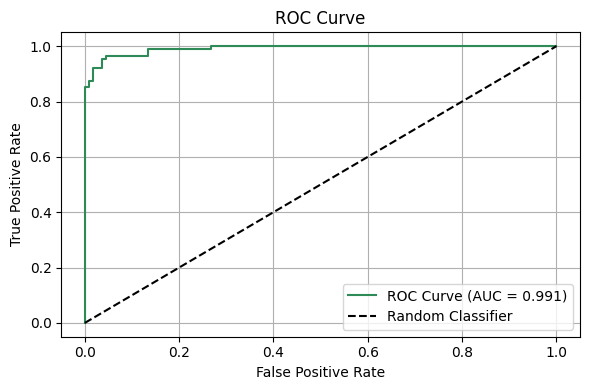

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
auc_score = roc_auc_score(y_test, y_proba[:, 1])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})", color="seagreen")
ax.plot([0, 1], [0, 1], "k--", label="Random Classifier")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
ax.grid(True)
fig.tight_layout()

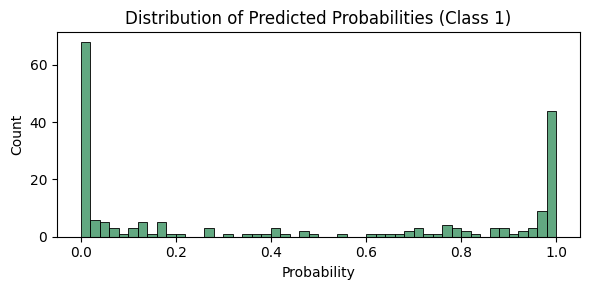

In [ ]:
# Predicted probabilities distribution
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(y_proba[:, 1], bins=50, color="seagreen", ax=ax)
ax.set_title("Distribution of Predicted Probabilities (Class 1)")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
fig.tight_layout()